In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm1d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [4]:
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, h_reshaped, encoder_states):
        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool1d( attention_input, attention_input.size(2), stride=attention_input.size(2))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool1d( attention_input, attention_input.size(2), stride=attention_input.size(2))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool1d( attention_input, 2, attention_input.size(2), stride=attention_input.size(2))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(attention_input)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).expand_as(encoder_states)
        return encoder_states * scale

In [5]:
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

In [6]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)

In [7]:
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        hidden_size = 32
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)
    def forward(self, h_reshaped, x_out):
        x = torch.cat((h_reshaped, x_out), dim=2)
        x_compress = self.compress(x)
        x_compress = self.spatial(x_compress)
        scale = F.sigmoid(x_compress) # broadcasting
        output = x * scale
        output = self.linear(output)

        return output

In [8]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, h_reshaped, encoder_states):
        h_reshaped = h_reshaped.transpose(0,1)
        encoder_states = encoder_states.transpose(0,1)
        h_reshaped = self.conv1(h_reshaped)
        encoder_states = self.conv2(encoder_states)
        x_out = self.ChannelGate(h_reshaped, encoder_states)
        if not self.no_spatial:
            x_out = self.SpatialGate(h_reshaped, x_out)
        x_out = self.conv3(x_out)
        x_out = x_out.transpose(0,1)
        return x_out

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [10]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)

        self.attention = CBAM(64)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        context_vector = self.attention(h_reshaped, encoder_states)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [13]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[0.0239],
        [0.0241],
        [0.0246],
        [0.0242],
        [0.0239]], device='cuda:0', grad_fn=<AddmmBackward0>)


D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [15]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [16]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [17]:
df_for_training=df[feature_names].astype(float)

In [18]:
df_for_training.shape

(11524, 22)

In [19]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [20]:
trainX=[]
trainY=[]

In [21]:
n_future=1
n_past=20

In [22]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [23]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [24]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [25]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [26]:
data,label=random_shuffle(trainX,trainY)

In [27]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [29]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.12854143977165222
Epoch: 1 Loss: 0.13935549557209015
Epoch: 2 Loss: 0.03907208889722824
Epoch: 3 Loss: 0.28258466720581055
Epoch: 4 Loss: 0.07238707691431046
Epoch: 5 Loss: 0.05575511232018471
Epoch: 6 Loss: 0.02230638638138771
Epoch: 7 Loss: 0.07883264124393463
Epoch: 8 Loss: 0.03155741095542908
Epoch: 9 Loss: 0.0280765350908041
Epoch: 10 Loss: 0.0965423732995987
Epoch: 11 Loss: 0.14799168705940247
Epoch: 12 Loss: 0.08827002346515656
Epoch: 13 Loss: 0.07579713314771652
Epoch: 14 Loss: 0.016989463940262794
Epoch: 15 Loss: 0.03334105759859085
Epoch: 16 Loss: 0.009908931329846382
Epoch: 17 Loss: 0.04296283796429634
Epoch: 18 Loss: 0.04943445324897766
Epoch: 19 Loss: 0.04649694263935089
Epoch: 20 Loss: 0.04027742147445679
Epoch: 21 Loss: 0.05235280469059944
Epoch: 22 Loss: 0.03627533093094826
Epoch: 23 Loss: 0.05619288980960846
Epoch: 24 Loss: 0.06381100416183472
Epoch: 25 Loss: 0.03432600945234299
Epoch: 26 Loss: 0.043896064162254333
Epoch: 27 Loss: 0.053668223321437836


Epoch: 222 Loss: 0.004759912379086018
Epoch: 223 Loss: 0.031945329159498215
Epoch: 224 Loss: 0.02458805963397026
Epoch: 225 Loss: 0.01015244796872139
Epoch: 226 Loss: 0.005370825529098511
Epoch: 227 Loss: 0.00910407118499279
Epoch: 228 Loss: 0.01786900870501995
Epoch: 229 Loss: 0.011782294139266014
Epoch: 230 Loss: 0.00985846109688282
Epoch: 231 Loss: 0.02547004073858261
Epoch: 232 Loss: 0.013287542387843132
Epoch: 233 Loss: 0.012879492715001106
Epoch: 234 Loss: 0.012669726274907589
Epoch: 235 Loss: 0.02967657893896103
Epoch: 236 Loss: 0.02269083261489868
Epoch: 237 Loss: 0.02897731028497219
Epoch: 238 Loss: 0.015925252810120583
Epoch: 239 Loss: 0.020373566076159477
Epoch: 240 Loss: 0.0069179171696305275
Epoch: 241 Loss: 0.02139630727469921
Epoch: 242 Loss: 0.0038735507987439632
Epoch: 243 Loss: 0.026119675487279892
Epoch: 244 Loss: 0.010082732886075974
Epoch: 245 Loss: 0.010090744122862816
Epoch: 246 Loss: 0.006504608318209648
Epoch: 247 Loss: 0.017912620678544044
Epoch: 248 Loss: 0.0

Epoch: 439 Loss: 0.01758272759616375
Epoch: 440 Loss: 0.008662237785756588
Epoch: 441 Loss: 0.010763779282569885
Epoch: 442 Loss: 0.012254796922206879
Epoch: 443 Loss: 0.014050937257707119
Epoch: 444 Loss: 0.002946243155747652
Epoch: 445 Loss: 0.014612985774874687
Epoch: 446 Loss: 0.007063345052301884
Epoch: 447 Loss: 0.010765103623270988
Epoch: 448 Loss: 0.028237253427505493
Epoch: 449 Loss: 0.02114410512149334
Epoch: 450 Loss: 0.007349457126110792
Epoch: 451 Loss: 0.015061276033520699
Epoch: 452 Loss: 0.025540243834257126
Epoch: 453 Loss: 0.0112433061003685
Epoch: 454 Loss: 0.0037514111027121544
Epoch: 455 Loss: 0.009126336313784122
Epoch: 456 Loss: 0.006661335006356239
Epoch: 457 Loss: 0.014231087639927864
Epoch: 458 Loss: 0.007377845235168934
Epoch: 459 Loss: 0.008770308457314968
Epoch: 460 Loss: 0.012647933326661587
Epoch: 461 Loss: 0.007474137470126152
Epoch: 462 Loss: 0.0069606974720954895
Epoch: 463 Loss: 0.00432866346091032
Epoch: 464 Loss: 0.006159707438200712
Epoch: 465 Loss

Epoch: 656 Loss: 0.020922664552927017
Epoch: 657 Loss: 0.0027042008005082607
Epoch: 658 Loss: 0.022349515929818153
Epoch: 659 Loss: 0.014066137373447418
Epoch: 660 Loss: 0.0164817925542593
Epoch: 661 Loss: 0.01408409234136343
Epoch: 662 Loss: 0.006683344952762127
Epoch: 663 Loss: 0.01743393763899803
Epoch: 664 Loss: 0.006185163743793964
Epoch: 665 Loss: 0.00789635255932808
Epoch: 666 Loss: 0.014512278139591217
Epoch: 667 Loss: 0.007627083919942379
Epoch: 668 Loss: 0.007307778112590313
Epoch: 669 Loss: 0.008696675300598145
Epoch: 670 Loss: 0.008713153190910816
Epoch: 671 Loss: 0.02271617203950882
Epoch: 672 Loss: 0.00777280330657959
Epoch: 673 Loss: 0.005005553364753723
Epoch: 674 Loss: 0.0060272216796875
Epoch: 675 Loss: 0.0034872787073254585
Epoch: 676 Loss: 0.0071434928104281425
Epoch: 677 Loss: 0.006610194221138954
Epoch: 678 Loss: 0.0071100397035479546
Epoch: 679 Loss: 0.030751094222068787
Epoch: 680 Loss: 0.019739843904972076
Epoch: 681 Loss: 0.003626186866313219
Epoch: 682 Loss: 

Epoch: 873 Loss: 0.005705417133867741
Epoch: 874 Loss: 0.005312764085829258
Epoch: 875 Loss: 0.0063292765989899635
Epoch: 876 Loss: 0.00516097154468298
Epoch: 877 Loss: 0.004018370062112808
Epoch: 878 Loss: 0.004538916517049074
Epoch: 879 Loss: 0.0059954700991511345
Epoch: 880 Loss: 0.004381680395454168
Epoch: 881 Loss: 0.005741440691053867
Epoch: 882 Loss: 0.008864600211381912
Epoch: 883 Loss: 0.013301990926265717
Epoch: 884 Loss: 0.012482530437409878
Epoch: 885 Loss: 0.006123978644609451
Epoch: 886 Loss: 0.013453750871121883
Epoch: 887 Loss: 0.016111133620142937
Epoch: 888 Loss: 0.011671962216496468
Epoch: 889 Loss: 0.01616577059030533
Epoch: 890 Loss: 0.006886608898639679
Epoch: 891 Loss: 0.006366751156747341
Epoch: 892 Loss: 0.009986788034439087
Epoch: 893 Loss: 0.014572380110621452
Epoch: 894 Loss: 0.00343749625608325
Epoch: 895 Loss: 0.011082015931606293
Epoch: 896 Loss: 0.009702559560537338
Epoch: 897 Loss: 0.005986824631690979
Epoch: 898 Loss: 0.009240840561687946
Epoch: 899 Lo

In [30]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [31]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [32]:
predictions = np.array(predictions)

In [33]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [34]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

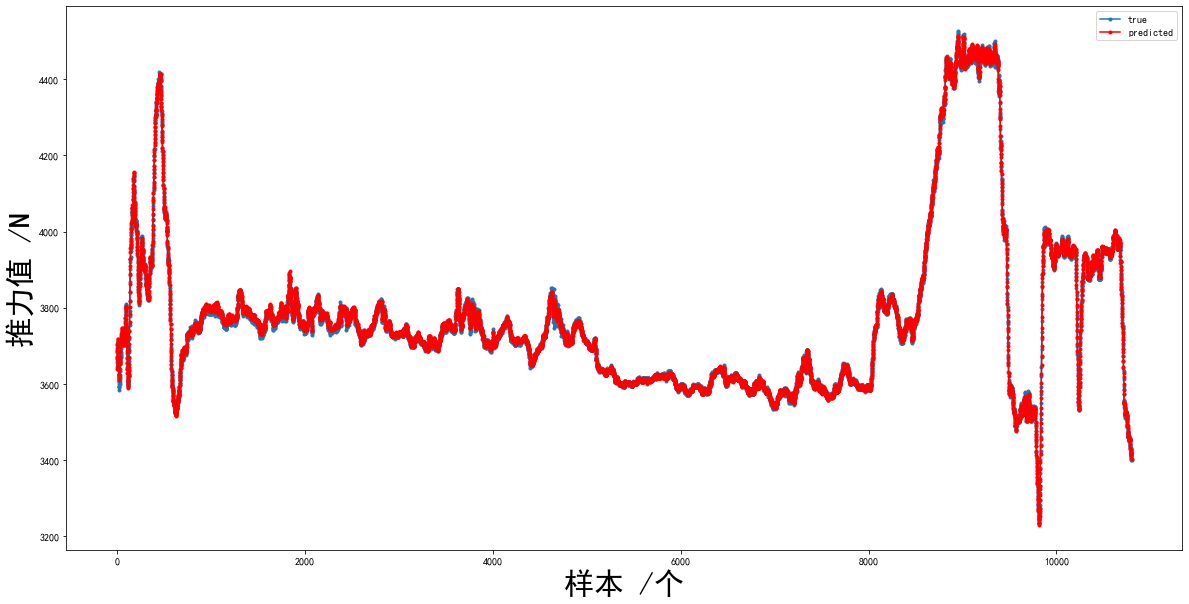

In [35]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();